In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from model import FusionDenoiser

In [4]:
torch.manual_seed(43)
np.random.seed(43)

In [2]:
from dataset import FocalDataset

In [3]:
ds = FocalDataset(input_channels=1, output_channels=3, augment=True, normalize=True)

In [4]:
stack, gt = ds[2]

In [5]:
stack.shape

torch.Size([8, 1, 512, 512])

In [6]:
gt.shape

torch.Size([3, 512, 512])

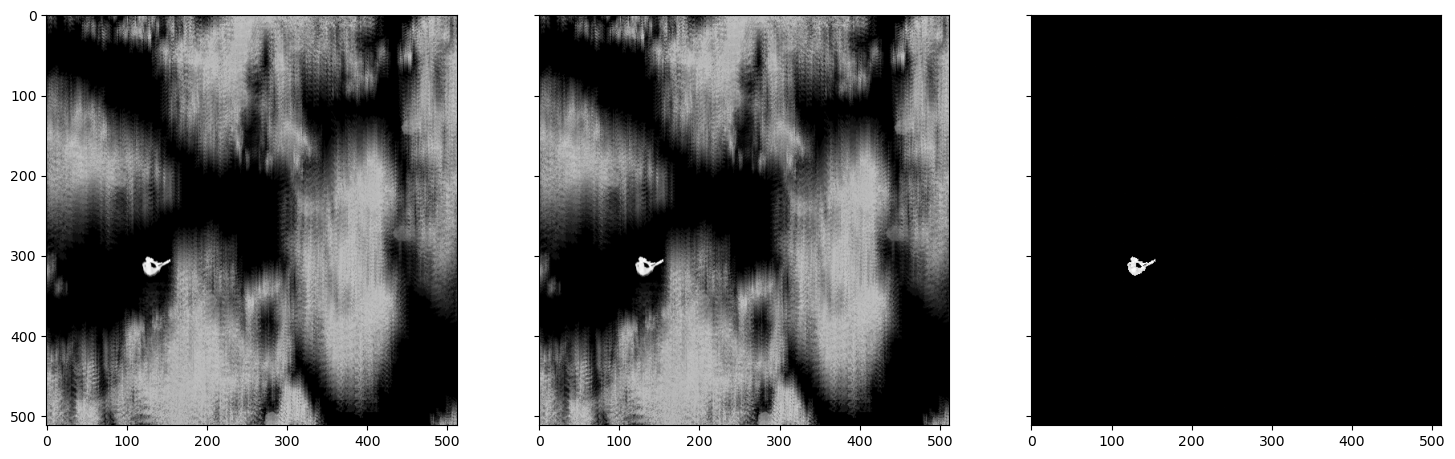

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18,10), sharey=True)

axes[0].imshow(np.moveaxis(stack[0].numpy(), 0,-1), cmap='gray')
axes[1].imshow(np.moveaxis(stack[1].numpy(), 0,-1), cmap='gray')
axes[2].imshow(np.moveaxis(gt.numpy(), 0,-1), cmap='gray')

In [10]:
# normalization constants used by pretrained IFCNN
# only really needed when using pretrained weights
# may be a good idea to adapt IFCNN to be similar to SwinIR in the way it works with image pixel range
mean = [0.485, 0.456, 0.406] #[0.46]*3
std = [0.229, 0.224, 0.225] #[0.225]*3

In [11]:
trial_mode = 2  # random, lytro, integrals

In [12]:
# Source: https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745/2
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [13]:
if trial_mode == 0:
    inp = torch.randn(16, 4, 1, 128, 128)
    inp = inp.repeat(1, 1, 3, 1, 1) # repeat gray channels as faux rgb
elif trial_mode == 1:
    trans = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Resize((128, 128), antialias=True),
    ] + ([AddGaussianNoise(std=0.015)] if trial_mode == 1 else []) + [   # Add noise to lytro images to see SwinIR effect
        transforms.Normalize(mean=mean, std=std),
    ])
    
    if trial_mode == 1:
        paths = glob('./lytro/*.jpg')
        
    inp = torch.stack([trans(Image.open(p)) for p in paths])[None, :]
elif trial_mode == 2:
    inp = transforms.Resize((128, 128), antialias=True)(ds[5][0])[None, :]
    
inp = inp.cuda()
inp.shape  # batch, n_focal_lengths, channels, dim1, dim2

torch.Size([1, 8, 3, 128, 128])

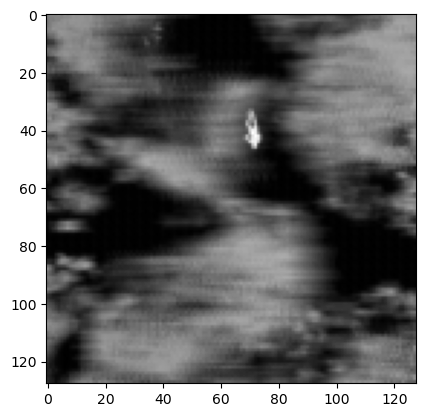

In [14]:
plt.imshow(inp[0,0,0].cpu(), cmap='gray')

In [15]:
inp.mean().item(), inp.std().item()

(0.38773104548454285, 0.12404617667198181)

In [16]:
# limited to img_size=128 when using pretrained=True, as SwinIR does not have pretrained weights for that size
model = FusionDenoiser(img_size=128, swin_version='V2', use_checkpoint=True, pretrained=True)
model = model.cuda().eval()

No pretrained weights available for grayscale Swin V2


In [17]:
with torch.no_grad():
    fused, denoised = model(inp)

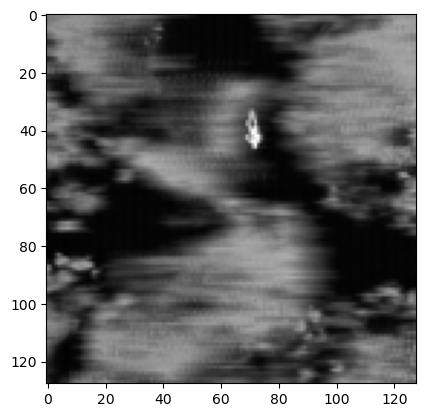

In [18]:
plt.imshow(fused[0,0].cpu(), cmap='gray')

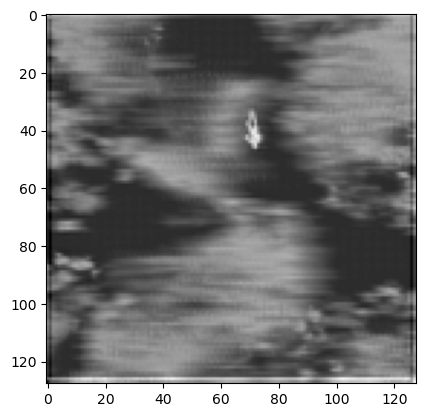

In [19]:
plt.imshow(denoised[0,0].cpu(), cmap='gray')

Text(0.5, 1.0, 'Denoised')

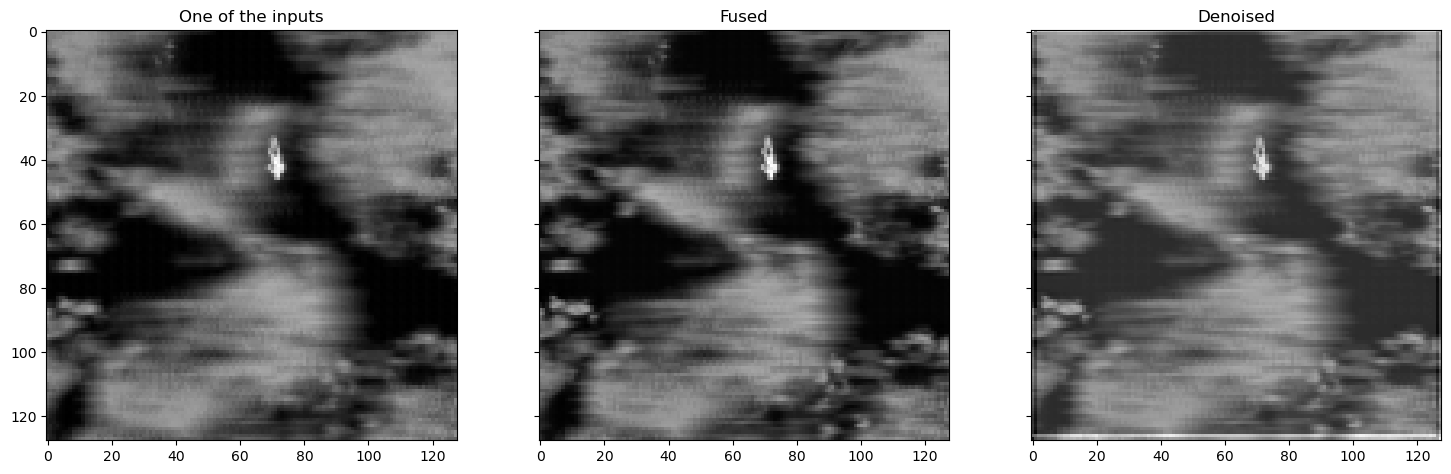

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18,10), sharey=True)

axes[0].imshow(inp[0,0,0].cpu(), cmap='gray')
axes[1].imshow(fused[0,0].cpu(), cmap='gray')
axes[2].imshow(denoised[0,0].cpu(), cmap='gray')

axes[0].set_title('One of the inputs')
axes[1].set_title('Fused')
axes[2].set_title('Denoised')

# TODO

- generate AOS integral data
- Dataset with augmentation (random 0°, 90°, 180°, 270° rotation + random flip, maybe random crop, maybe noise). Data seems to be quite abundant, so just rotation and flips may be sufficient
- evaluation function
- training loop with logging, validation evaluation and checkpointing
- self-ensemble for final predictions (not used for training)

In [23]:
j = np.arange(2*3*1*2).reshape(2, 3, 1, 2)
j

array([[[[ 0,  1]],

        [[ 2,  3]],

        [[ 4,  5]]],


       [[[ 6,  7]],

        [[ 8,  9]],

        [[10, 11]]]])

In [52]:
num_rots = np.random.randint(4)
j = np.rot90(j, num_rots, (-3, -2))

if np.random.rand() > 0.5:
    j = np.flip(j, -2)

if np.random.rand() > 0.5:
    j = np.flip(j, -3)

In [24]:
np.repeat(j, 3, -2)

array([[[[ 0,  1],
         [ 0,  1],
         [ 0,  1]],

        [[ 2,  3],
         [ 2,  3],
         [ 2,  3]],

        [[ 4,  5],
         [ 4,  5],
         [ 4,  5]]],


       [[[ 6,  7],
         [ 6,  7],
         [ 6,  7]],

        [[ 8,  9],
         [ 8,  9],
         [ 8,  9]],

        [[10, 11],
         [10, 11],
         [10, 11]]]])